In [ ]:
import os
import time
import random
import math
import re
import sys
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from osgeo import gdal, ogr, osr

from tqdm import tqdm

import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
NLCD_CLASSES = [0, 11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95] # 16 classes + 1 nodata class ("0").
NUM_DFC2021_CLASS = 5 # Output classes (0: Water, 1: Tree Canopy, 2: Low Vegetation , 3: Impervious, 4: None)
SEED_NUM = 0
NUM_SPLITS = 10 # Train in 1 epoch using image in (bach_size * NUM_SPLITS ** 2, 4, 3880 / NUM_SPLITS, 3880 / NUM_SPLITS)
SPL_WH = int(3880 / NUM_SPLITS)
NLCD_IDX_TO_REDUCED_LC_MAP = np.array([
    4,#  0 No data 0
    0,#  1 Open Water
    4,#  2 Ice/Snow
    2,#  3 Developed Open Space
    3,#  4 Developed Low Intensity
    3,#  5 Developed Medium Intensity
    3,#  6 Developed High Intensity
    3,#  7 Barren Land
    1,#  8 Deciduous Forest
    1,#  9 Evergreen Forest
    1,# 10 Mixed Forest
    1,# 11 Shrub/Scrub
    2,# 12 Grassland/Herbaceous
    2,# 13 Pasture/Hay
    2,# 14 Cultivated Crops
    1,# 15 Woody Wetlands
    1,# 16 Emergent Herbaceious Wetlands
])

DW_IDX_TO_REDUCED_LC_MAP = np.array([
    0,#  0 water -> Water
    1,#  1 trees -> TC
    2,#  2 grass -> LV
    1,#  3 flooded_vegetation -> TC
    2,#  4 crops -> LV
    2,#  5 shrub_and_scrub -> LV
    3,#  6 built -> Im
    2,#  7 bare -> LV
    4,#  8 snow_and_ice -> None
])

# set rescaling weights given to each class in loss function based on the distribution of target classes,
# (W, TC, LV, I) = (0.09, 0.453, 0.376, 0.081), and considering the percentage of None as 1/5 = 0.2
LOSS_WEIGHT = 1 / np.array([0.09, 0.453, 0.376, 0.081, 0.2]) / 5

# Data Preparation

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/JPMC3-2-pt2y/data/training_set_naip_nlcd_2017.csv')

num_we_select = 2000     # Roughly 60M * num_we_select size is required!!

In [ ]:
random.seed(SEED_NUM)

os.makedirs('/content/drive/MyDrive/JPMC3-2-pt2y/data', exist_ok = True)

!rm -rf /content/drive/MyDrive/JPMC3-2-pt2y/data/image/*
!rm -rf /content/drive/MyDrive/JPMC3-2-pt2y/data/label/*

ris_dl = random.sample(range(len(df)), k = num_we_select)
df_dl = df.iloc[ris_dl]  

df_dl['image_fn'].to_csv('/content/drive/MyDrive/JPMC3-2-pt2y/data/image_fns.txt', header = False, index = False)
df_dl['label_fn'].to_csv('/content/drive/MyDrive/JPMC3-2-pt2y/data/label_fns.txt', header = False, index = False)

start_time = time.time()
!wget --quiet -P /content/drive/MyDrive/JPMC3-2-pt2y/data/image -i /content/drive/MyDrive/JPMC3-2-pt2y/data/image_fns.txt
!wget --quiet -P /content/drive/MyDrive/JPMC3-2-pt2y/data/label -i /content/drive/MyDrive/JPMC3-2-pt2y/data/label_fns.txt
(time.time() - start_time) / 60

# Train model

In [ ]:
class FCN_l5(nn.Module):
    # FCN model with 5 layers
    # Input: 4D tensor (batch_size, num_input_channels, input_size, input_size)

    def __init__(self, num_input_channels, num_output_classes, kernel_size = 3, padding = 1, num_filters = 64):
        super(FCN_l5, self).__init__()

        self.conv1 = nn.Conv2d(num_input_channels, num_filters,
                               kernel_size = kernel_size, stride = 1, padding = padding)
        self.conv2 = nn.Conv2d(num_filters, num_filters,
                               kernel_size = kernel_size, stride = 1, padding = padding)
        self.last = nn.Conv2d(num_filters, num_output_classes,
                               kernel_size = 1          , stride = 1, padding = 0)
        
    def forward(self, inputs):
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = self.last(x)

        return x  # Output: 4D tensor (batch_size, num_output_classes, input_size, input_size)

In [ ]:
def padding(image_np, rgb_or_gray = "rgb", image_or_label = "image"):
    if (image_or_label == "image") & (rgb_or_gray == "rgb"):
        width, height = image_np.shape[1], image_np.shape[2]
    else:
        width, height = image_np.shape[0], image_np.shape[1]

    w_x_bef = int((3880 - width) / 2)
    w_x_aft = 3880 - width - w_x_bef
    w_y_bef = int((3880 - height) / 2)
    w_y_aft = 3880 - height - w_y_bef
    
    if rgb_or_gray == "rgb":
        if image_or_label == "image":
            pad_width = ((0, 0), (w_x_bef, w_x_aft), (w_y_bef, w_y_aft))
        elif image_or_label == "label":
            pad_width = ((w_x_bef, w_x_aft), (w_y_bef, w_y_aft), (0, 0))
        else:
            print ('Specify image_or_label by "image" or "label"')
            sys.exit(1)

        image_np = np.pad(image_np, pad_width,
                          constant_values = ((0, 0), (0, 0), (0, 0)))
    elif rgb_or_gray == "gray":
        image_np = np.pad(image_np, ((w_x_bef, w_x_aft), (w_y_bef, w_y_aft)),
                          constant_values = ((4, 4), (4, 4)))
    else:
        print ('Specify rgb_or_gray by "rgb" or "gray"')
        sys.exit(1)
    
    return(image_np)

In [ ]:
def calc_IoU(pred_label, g_truth_label, calc_label):
    isect = torch.sum(10 * pred_label + g_truth_label == 11 * calc_label)
    union = torch.sum(pred_label == calc_label) + torch.sum(g_truth_label == calc_label) - isect

    return(isect / union)

In [ ]:
!nvidia-smi

Fri Nov 18 09:34:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def training(model, epoch, bsize, l_rate, ite_show_log = 32):
    def make_train_data_targets(ris):
        image_np_s = []
        image_loader = sorted(
            [file for file in os.listdir('/content/drive/MyDrive/JPMC3-2-pt2y/data/image/') 
            if file.endswith('.tif')])
        for file in [image_loader[ri] for ri in ris]:
            ds = gdal.Open(os.path.join('/content/drive/MyDrive/JPMC3-2-pt2y/data/image/', file), gdal.GA_ReadOnly)
            image_np = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
            image_np = padding(image_np, rgb_or_gray = "rgb", image_or_label = "image")
            for i in range(NUM_SPLITS):
                for ii in range(NUM_SPLITS):
                    image_np_s.append(image_np[:, i * SPL_WH:(i + 1) * SPL_WH, ii * SPL_WH:(ii + 1) * SPL_WH])            
                    # DAug
                    gamma =1.6
                    image_np_s.append(255 * ((image_np[:, i * SPL_WH:(i + 1) * SPL_WH, ii * SPL_WH:(ii + 1) * SPL_WH] / 255) ** (1/gamma)))  

        image_np_s = np.array(image_np_s) / 255
        assert image_np_s.shape == (2 * bsize * NUM_SPLITS ** 2, 4, SPL_WH, SPL_WH)

        label_np_s = []
        label_loader = sorted(
            [file for file in os.listdir('/content/drive/MyDrive/JPMC3-2-pt2y/data/label/') 
            if file.endswith('.tif')])
        for file in [label_loader[ri] for ri in ris]:
            ds = gdal.Open(os.path.join('/content/drive/MyDrive/JPMC3-2-pt2y/data/label/', file), gdal.GA_ReadOnly)
            label_np = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
            label_np = np.squeeze(label_np)
            for i,ele in enumerate(NLCD_CLASSES):
                label_np = np.where(label_np == ele, NLCD_IDX_TO_REDUCED_LC_MAP[i], label_np)

            label_np = padding(label_np, rgb_or_gray = "gray", image_or_label = "label")
            for i in range(NUM_SPLITS):
                for ii in range(NUM_SPLITS):
                    label_np_s.append(label_np[i * SPL_WH:(i + 1) * SPL_WH, ii * SPL_WH:(ii + 1) * SPL_WH])    
                    # DAug
                    label_np_s.append(label_np[i * SPL_WH:(i + 1) * SPL_WH, ii * SPL_WH:(ii + 1) * SPL_WH])   

        label_np_s = np.array(label_np_s)
        assert label_np_s.shape == (2 * bsize * NUM_SPLITS ** 2, SPL_WH, SPL_WH)

        train_data = torch.from_numpy(image_np_s).float().to(device)
        train_targets = torch.from_numpy(label_np_s).type(torch.LongTensor).to(device)
        # train_targets_dw = torch.from_numpy(label_np_dw_s).type(torch.LongTensor).to(device)
        return(train_data, train_targets)
        # return(train_data, train_targets, train_targets_dw)

    def make_test_data_targets(ris):
        test_image_np_s = []
        test_image_loader = sorted(
            [file for file in os.listdir('/content/drive/MyDrive/JPMC3-2-pt2y/data/test_image/') 
            if file.endswith('.tif')])
        for file in test_image_loader:
            ds = gdal.Open(os.path.join('/content/drive/MyDrive/JPMC3-2-pt2y/data/test_image/', file), gdal.GA_ReadOnly)
            test_image_np = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
            test_image_np = padding(test_image_np, rgb_or_gray = "rgb", image_or_label = "image")
            for i in range(NUM_SPLITS):
                for ii in range(NUM_SPLITS):
                    test_image_np_s.append(test_image_np[:, i * SPL_WH:(i + 1) * SPL_WH, ii * SPL_WH:(ii + 1) * SPL_WH])

        test_image_np_s = np.array(test_image_np_s) / 255
        assert test_image_np_s.shape == (len(test_image_loader) * NUM_SPLITS ** 2, 4, SPL_WH, SPL_WH)

        test_label_np_s = []
        test_label_loader = sorted(
            [file for file in os.listdir('/content/drive/MyDrive/JPMC3-2-pt2y/data/test_label_hr/') 
            if file.endswith('.npy') & (file.find("gray") > -1)])
        for file in test_label_loader:
            test_label_np = np.load(
                os.path.join('/content/drive/MyDrive/JPMC3-2-pt2y/data/test_label_hr/', file), gdal.GA_ReadOnly)
            test_label_np = padding(test_label_np, rgb_or_gray = "gray", image_or_label = "label")
            for i in range(NUM_SPLITS):
                for ii in range(NUM_SPLITS):
                    test_label_np_s.append(test_label_np[i * SPL_WH:(i + 1) * SPL_WH, ii * SPL_WH:(ii + 1) * SPL_WH])

        test_label_np_s = np.array(test_label_np_s)
        assert test_label_np_s.shape == (len(test_label_loader) * NUM_SPLITS ** 2, SPL_WH, SPL_WH)
        assert len(test_image_loader) == len(test_label_loader)

        test_data = torch.from_numpy(test_image_np_s).float().to(device)
        test_targets = torch.from_numpy(test_label_np_s).type(torch.LongTensor).to(device)
        return(test_data, test_targets, test_image_np_s, test_label_np_s)
    
    def reshape_data(data):
        if data.ndim == 4:
            reshaped_data = np.empty((2, 4, 0, 3880))
            for i in range(NUM_SPLITS):
                reshaped_data_c = np.empty((2, 4, 388, 0))
                for ii in range(NUM_SPLITS):
                    reshaped_data_c = np.append(reshaped_data_c, data[[i * 10 + ii, 100 + i * 10 + ii], :, :, :], 3)
                reshaped_data = np.append(reshaped_data, reshaped_data_c, 2)
        else:
            reshaped_data =  torch.empty((2, 0, 3880)).to(device)
            for i in range(NUM_SPLITS):
                reshaped_data_c = torch.empty((2, 388, 0)).to(device)
                for ii in range(NUM_SPLITS):
                    reshaped_data_c = torch.cat((reshaped_data_c, data[[i * 10 + ii, 100 + i * 10 + ii], :, :]), 2)
                reshaped_data = torch.cat((reshaped_data, reshaped_data_c), 1)
        
        return(reshaped_data)

    start_time = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr = l_rate)
    criterion = nn.CrossEntropyLoss(weight = torch.tensor(LOSS_WEIGHT).type(torch.cuda.FloatTensor).to(device))
    # criterion = nn.CrossEntropyLoss(weight = torch.tensor(LOSS_WEIGHT).type(torch.FloatTensor).to(device))

    losses = []
    test_losses = []
    IoU = [[]]
    test_IoU = [[]]
    for i in range(NUM_DFC2021_CLASS - 1): IoU.append([]), test_IoU.append([])

    for ite in tqdm(range(epoch * int(num_we_select / (bsize * 2)))):

        ## Train
        ris = random.sample(range(num_we_select), k = bsize)
        train_data, train_targets = make_train_data_targets(ris)
        # train_data, train_targets, train_targets_dw = make_train_data_targets(ris)

        preds_s = np.empty((0, SPL_WH, SPL_WH))
        for i in range(int(train_data.shape[0] / bsize)):
            optimizer.zero_grad()
            outputs = model(train_data[i * bsize:(i + 1) * bsize])
            preds = torch.max(outputs, dim = 1).indices
            preds_s = np.append(preds_s, preds.to('cpu').detach().numpy().copy(), 0)
            loss = criterion(outputs, train_targets[i * bsize:(i + 1) * bsize])
            loss.backward()

            optimizer.step() ### For GPU
            # xm.optimizer_step(optimizer, barrier = True) ### For TPU

        losses.append(loss.item())
        if train_data.shape[0] % bsize > 0:
            optimizer.zero_grad()
            outputs = model(train_data[(i + 1) * bsize:])
            preds = torch.max(outputs, dim = 1).indices
            preds_s = np.append(preds_s, preds.to('cpu').detach().numpy().copy(), 0)
            loss = criterion(outputs, train_targets[(i + 1) * bsize:])
            loss.backward()

            optimizer.step() ### For GPU
            # xm.optimizer_step(optimizer, barrier = True) ### For TPU           

        preds_s = torch.tensor(preds_s).to(device)
        for i in range(NUM_DFC2021_CLASS): IoU[i].append(calc_IoU(preds_s, train_targets, i).item())

        if ite == 0:
            print("\nmemory_usage_after_train")
            print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
            print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
            print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

        ## Test
        if ite == 0:
            test_data, test_targets, test_image_np_s, test_label_np_s = make_test_data_targets(ris)

        test_preds_s = np.empty((0, SPL_WH, SPL_WH))
        for i in range(int(test_data.shape[0] / bsize)):
            test_outputs = model(test_data[i * bsize:(i + 1) * bsize])
            test_preds = torch.max(test_outputs, dim = 1).indices
            test_preds_s = np.append(test_preds_s, test_preds.to('cpu').detach().numpy().copy(), 0)
            test_loss = criterion(test_outputs, test_targets[i * bsize:(i + 1) * bsize])
        
        test_losses.append(test_loss.item())
        if test_data.shape[0] % bsize > 0:
            test_outputs = model(test_data[(i + 1) * bsize:])
            test_preds = torch.max(test_outputs, dim = 1).indices
            test_preds_s = np.append(test_preds_s, test_preds.to('cpu').detach().numpy().copy(), 0)

        test_preds_s = torch.tensor(test_preds_s).to(device)
        for i in range(NUM_DFC2021_CLASS): test_IoU[i].append(calc_IoU(test_preds_s, test_targets, i).item())
        if ite == 0:
            print("\nmemory_usage_after_test")
            print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
            print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
            print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

        time_lapsed = time.time() - start_time
        if ite % ite_show_log == 0:
            print(f'\n{int(time_lapsed // 60)} min {int(time_lapsed % 60)} sec lapsed, \n \
                    {ite} steps: Loss = {losses[-1]:.4f}, Test Loss = {test_losses[-1]:.4f}, \n \
                    IoU (Water) = {IoU[0][-1]:.4f}, IoU (Tree Canopy) = {IoU[1][-1]:.4f}, \n \
                    IoU (Low Vegetation) = {IoU[2][-1]:.4f}, IoU (Impervious) = {IoU[3][-1]:.4f}, \n \
                    Test IoU (Water) = {test_IoU[0][-1]:.4f}, Test IoU (Tree Canopy) = {test_IoU[1][-1]:.4f}, \n \
                    Test IoU (Low Vegetation) = {test_IoU[2][-1]:.4f}, Test IoU (Impervious) = {test_IoU[3][-1]:.4f}'
                    )
            torch.save(model.state_dict(), f'/content/drive/MyDrive/JPMC3-2-pt2y/basemodels_DA_nlcdonly/fcn_221114_step{ite}')
            
    test_preds_s = reshape_data(test_preds_s)
    test_image_np_s = reshape_data(test_image_np_s)
    test_label_np_s = reshape_data(torch.from_numpy(test_label_np_s).to(device))
            
    print(f'\n{int(time_lapsed // 60)} min {int(time_lapsed % 60)} sec lapsed')     
    torch.save(model.state_dict(), f'/content/drive/MyDrive/JPMC3-2-pt2y/basemodels_DA_nlcdonly/fcn_221114_final')    
    with open(f'/content/drive/MyDrive/JPMC3-2-pt2y/basemodels_DA_nlcdonly/results', 'wb') as file:
        pickle.dump([losses, test_losses, IoU, test_IoU], file)     
    return(losses, test_losses, IoU, test_IoU, test_preds_s, test_image_np_s, test_label_np_s)

In [ ]:
def plot_log(losses, test_losses, IoU, test_IoU, rolling, none_flag = True):   
    plt.figure(figsize = (10, 5))
    _losses = pd.Series(losses).rolling(rolling).mean()
    _test_losses = pd.Series(test_losses).rolling(rolling).mean()
    plt.plot(_losses, label = 'train')
    plt.plot(_test_losses, label = 'test')
    plt.xlabel('# Steps')
    plt.ylabel('Loss')
    # plt.ylim((0,5))
    plt.legend()
    plt.title('Loss plot')
    plt.show()

    all_class_names = ['Water', 'Tree Canopy', 'Low Vegetation', 'Impervious', 'None']
    if not(none_flag):
        IoU = IoU[:-1]
        test_IoU = test_IoU[:-1]
        all_class_names = all_class_names[:-1]

    plt.figure(figsize = (10, 5))
    for i, ious in enumerate(IoU):
        ious = pd.Series(ious).rolling(rolling).mean()
        plt.plot(ious, label = all_class_names[i])
    plt.legend()
    plt.xlabel('# Steps')
    plt.ylabel('Train IoU')
    plt.title('Train IoU plot (smoothed)')
    plt.show()

    plt.figure(figsize = (10, 5))
    for i, ious in enumerate(test_IoU):
        ious = pd.Series(ious).rolling(rolling).mean()
        plt.plot(ious, label = all_class_names[i])
    plt.legend()
    plt.xlabel('# Steps')
    plt.ylabel('Test IoU')
    plt.title('Test IoU plot')
    plt.show()

In [ ]:
torch.manual_seed(SEED_NUM)
random.seed(SEED_NUM)
np.random.seed(SEED_NUM)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') ### For GPU
# device = xm.xla_device() ### For TPU
print(device)        #TPU: xla:1, GPU: cuda:0, CPU: cpu

bsize = 2
l_rate = bsize*0.001/100

model = FCN_l5(num_input_channels = 4, num_output_classes = NUM_DFC2021_CLASS).to(device)
losses, test_losses, IoU, test_IoU, test_preds, test_image_np_s, test_label_np_s = \
             training(model, epoch = 1, bsize = bsize, l_rate = l_rate, ite_show_log = 16)

cuda:0


  0%|          | 0/500 [00:00<?, ?it/s]


memory_usage_after_train
torch.cuda.memory_allocated: 1.804347GB
torch.cuda.memory_reserved: 3.568359GB
torch.cuda.max_memory_reserved: 3.568359GB


  0%|          | 1/500 [00:35<4:57:45, 35.80s/it]


memory_usage_after_test
torch.cuda.memory_allocated: 3.076803GB
torch.cuda.memory_reserved: 4.017578GB
torch.cuda.max_memory_reserved: 4.017578GB

0 min 35 sec lapsed, 
                     0 steps: Loss = 0.9383, Test Loss = 1.4931, 
                     IoU (Water) = 0.0000, IoU (Tree Canopy) = 0.1097, 
                     IoU (Low Vegetation) = 0.2749, IoU (Impervious) = 0.0000, 
                     Test IoU (Water) = 0.0000, Test IoU (Tree Canopy) = 0.0000, 
                     Test IoU (Low Vegetation) = 0.2748, Test IoU (Impervious) = 0.0000


  3%|▎         | 17/500 [09:53<4:38:51, 34.64s/it]


9 min 53 sec lapsed, 
                     16 steps: Loss = 1.3352, Test Loss = 1.1427, 
                     IoU (Water) = 0.0000, IoU (Tree Canopy) = 0.4068, 
                     IoU (Low Vegetation) = 0.0040, IoU (Impervious) = 0.0000, 
                     Test IoU (Water) = 0.0000, Test IoU (Tree Canopy) = 0.6699, 
                     Test IoU (Low Vegetation) = 0.0014, Test IoU (Impervious) = 0.0000


  7%|▋         | 33/500 [19:09<4:30:06, 34.70s/it]


19 min 9 sec lapsed, 
                     32 steps: Loss = 0.6377, Test Loss = 0.9096, 
                     IoU (Water) = 0.3078, IoU (Tree Canopy) = 0.6100, 
                     IoU (Low Vegetation) = 0.5458, IoU (Impervious) = 0.0636, 
                     Test IoU (Water) = 0.2759, Test IoU (Tree Canopy) = 0.4305, 
                     Test IoU (Low Vegetation) = 0.2904, Test IoU (Impervious) = 0.0006


 10%|▉         | 49/500 [28:29<4:23:05, 35.00s/it]


28 min 29 sec lapsed, 
                     48 steps: Loss = 0.5163, Test Loss = 0.9372, 
                     IoU (Water) = 0.0165, IoU (Tree Canopy) = 0.6491, 
                     IoU (Low Vegetation) = 0.5524, IoU (Impervious) = 0.2105, 
                     Test IoU (Water) = 0.0095, Test IoU (Tree Canopy) = 0.4457, 
                     Test IoU (Low Vegetation) = 0.3360, Test IoU (Impervious) = 0.0013


 13%|█▎        | 65/500 [37:43<4:10:37, 34.57s/it]


37 min 43 sec lapsed, 
                     64 steps: Loss = 0.5410, Test Loss = 1.0584, 
                     IoU (Water) = 0.8318, IoU (Tree Canopy) = 0.6571, 
                     IoU (Low Vegetation) = 0.5269, IoU (Impervious) = 0.0065, 
                     Test IoU (Water) = 0.3254, Test IoU (Tree Canopy) = 0.7741, 
                     Test IoU (Low Vegetation) = 0.3338, Test IoU (Impervious) = 0.0017


 16%|█▌        | 81/500 [47:01<4:03:13, 34.83s/it]


47 min 1 sec lapsed, 
                     80 steps: Loss = 0.4644, Test Loss = 0.9609, 
                     IoU (Water) = 0.5535, IoU (Tree Canopy) = 0.6760, 
                     IoU (Low Vegetation) = 0.7493, IoU (Impervious) = 0.0000, 
                     Test IoU (Water) = 0.2111, Test IoU (Tree Canopy) = 0.7830, 
                     Test IoU (Low Vegetation) = 0.4474, Test IoU (Impervious) = 0.0000


 19%|█▉        | 97/500 [56:25<3:56:47, 35.25s/it]


56 min 25 sec lapsed, 
                     96 steps: Loss = 0.1152, Test Loss = 1.9430, 
                     IoU (Water) = 0.7595, IoU (Tree Canopy) = 0.7752, 
                     IoU (Low Vegetation) = 0.4707, IoU (Impervious) = 0.0840, 
                     Test IoU (Water) = 0.0340, Test IoU (Tree Canopy) = 0.7073, 
                     Test IoU (Low Vegetation) = 0.0241, Test IoU (Impervious) = 0.0072


 23%|██▎       | 113/500 [1:05:40<3:43:58, 34.72s/it]


65 min 40 sec lapsed, 
                     112 steps: Loss = 0.4936, Test Loss = 0.8917, 
                     IoU (Water) = 0.9673, IoU (Tree Canopy) = 0.5594, 
                     IoU (Low Vegetation) = 0.6931, IoU (Impervious) = 0.0111, 
                     Test IoU (Water) = 0.2055, Test IoU (Tree Canopy) = 0.7128, 
                     Test IoU (Low Vegetation) = 0.4302, Test IoU (Impervious) = 0.0225


 26%|██▌       | 129/500 [1:14:52<3:32:51, 34.42s/it]


74 min 52 sec lapsed, 
                     128 steps: Loss = 0.0628, Test Loss = 0.9199, 
                     IoU (Water) = 0.9235, IoU (Tree Canopy) = 0.6450, 
                     IoU (Low Vegetation) = 0.1484, IoU (Impervious) = 0.0640, 
                     Test IoU (Water) = 0.0575, Test IoU (Tree Canopy) = 0.7935, 
                     Test IoU (Low Vegetation) = 0.3972, Test IoU (Impervious) = 0.3113


 29%|██▉       | 145/500 [1:24:03<3:23:30, 34.40s/it]


84 min 3 sec lapsed, 
                     144 steps: Loss = 0.7633, Test Loss = 0.7167, 
                     IoU (Water) = 0.8733, IoU (Tree Canopy) = 0.5942, 
                     IoU (Low Vegetation) = 0.5114, IoU (Impervious) = 0.0337, 
                     Test IoU (Water) = 0.1701, Test IoU (Tree Canopy) = 0.7685, 
                     Test IoU (Low Vegetation) = 0.4727, Test IoU (Impervious) = 0.3151


 32%|███▏      | 161/500 [1:33:15<3:14:40, 34.46s/it]


93 min 15 sec lapsed, 
                     160 steps: Loss = 0.8829, Test Loss = 0.7236, 
                     IoU (Water) = 0.2244, IoU (Tree Canopy) = 0.7019, 
                     IoU (Low Vegetation) = 0.2452, IoU (Impervious) = 0.2686, 
                     Test IoU (Water) = 0.5138, Test IoU (Tree Canopy) = 0.7979, 
                     Test IoU (Low Vegetation) = 0.4535, Test IoU (Impervious) = 0.5033


 35%|███▌      | 177/500 [1:42:25<3:05:11, 34.40s/it]


102 min 25 sec lapsed, 
                     176 steps: Loss = 0.9797, Test Loss = 0.7846, 
                     IoU (Water) = 0.2480, IoU (Tree Canopy) = 0.7092, 
                     IoU (Low Vegetation) = 0.7428, IoU (Impervious) = 0.0490, 
                     Test IoU (Water) = 0.2678, Test IoU (Tree Canopy) = 0.7936, 
                     Test IoU (Low Vegetation) = 0.4150, Test IoU (Impervious) = 0.3016


 39%|███▊      | 193/500 [1:51:32<2:54:07, 34.03s/it]


111 min 32 sec lapsed, 
                     192 steps: Loss = 1.0062, Test Loss = 0.6290, 
                     IoU (Water) = 0.0000, IoU (Tree Canopy) = 0.7101, 
                     IoU (Low Vegetation) = 0.2516, IoU (Impervious) = 0.3683, 
                     Test IoU (Water) = 0.2084, Test IoU (Tree Canopy) = 0.7680, 
                     Test IoU (Low Vegetation) = 0.1335, Test IoU (Impervious) = 0.2324


 42%|████▏     | 209/500 [2:00:40<2:43:49, 33.78s/it]


120 min 40 sec lapsed, 
                     208 steps: Loss = 1.7474, Test Loss = 0.6836, 
                     IoU (Water) = 0.0000, IoU (Tree Canopy) = 0.8067, 
                     IoU (Low Vegetation) = 0.2209, IoU (Impervious) = 0.2278, 
                     Test IoU (Water) = 0.0000, Test IoU (Tree Canopy) = 0.8094, 
                     Test IoU (Low Vegetation) = 0.4653, Test IoU (Impervious) = 0.5039


 45%|████▌     | 225/500 [2:09:47<2:34:39, 33.74s/it]


129 min 47 sec lapsed, 
                     224 steps: Loss = 0.1048, Test Loss = 1.1615, 
                     IoU (Water) = 0.0785, IoU (Tree Canopy) = 0.8845, 
                     IoU (Low Vegetation) = 0.2709, IoU (Impervious) = 0.0186, 
                     Test IoU (Water) = 0.0798, Test IoU (Tree Canopy) = 0.7404, 
                     Test IoU (Low Vegetation) = 0.2308, Test IoU (Impervious) = 0.2010


 48%|████▊     | 241/500 [2:18:49<2:27:14, 34.11s/it]


138 min 49 sec lapsed, 
                     240 steps: Loss = 1.2144, Test Loss = 0.8368, 
                     IoU (Water) = 0.3117, IoU (Tree Canopy) = 0.5202, 
                     IoU (Low Vegetation) = 0.6904, IoU (Impervious) = 0.1354, 
                     Test IoU (Water) = 0.3589, Test IoU (Tree Canopy) = 0.4255, 
                     Test IoU (Low Vegetation) = 0.3568, Test IoU (Impervious) = 0.4303


 51%|█████▏    | 257/500 [2:27:48<2:19:37, 34.48s/it]


147 min 48 sec lapsed, 
                     256 steps: Loss = 2.0840, Test Loss = 0.9229, 
                     IoU (Water) = 0.9411, IoU (Tree Canopy) = 0.5759, 
                     IoU (Low Vegetation) = 0.6814, IoU (Impervious) = 0.0379, 
                     Test IoU (Water) = 0.4599, Test IoU (Tree Canopy) = 0.6220, 
                     Test IoU (Low Vegetation) = 0.4147, Test IoU (Impervious) = 0.1316


 55%|█████▍    | 273/500 [2:36:45<2:06:01, 33.31s/it]


156 min 45 sec lapsed, 
                     272 steps: Loss = 0.6716, Test Loss = 0.7356, 
                     IoU (Water) = 0.8226, IoU (Tree Canopy) = 0.4499, 
                     IoU (Low Vegetation) = 0.4405, IoU (Impervious) = 0.4705, 
                     Test IoU (Water) = 0.2923, Test IoU (Tree Canopy) = 0.7514, 
                     Test IoU (Low Vegetation) = 0.4685, Test IoU (Impervious) = 0.3583


 58%|█████▊    | 289/500 [2:45:34<1:55:26, 32.83s/it]


165 min 34 sec lapsed, 
                     288 steps: Loss = 0.5055, Test Loss = 0.7388, 
                     IoU (Water) = 0.7687, IoU (Tree Canopy) = 0.6292, 
                     IoU (Low Vegetation) = 0.6718, IoU (Impervious) = 0.1321, 
                     Test IoU (Water) = 0.4635, Test IoU (Tree Canopy) = 0.7919, 
                     Test IoU (Low Vegetation) = 0.4022, Test IoU (Impervious) = 0.4324


 61%|██████    | 305/500 [2:54:34<1:50:42, 34.07s/it]


174 min 34 sec lapsed, 
                     304 steps: Loss = 0.1603, Test Loss = 0.8020, 
                     IoU (Water) = 0.0543, IoU (Tree Canopy) = 0.7959, 
                     IoU (Low Vegetation) = 0.4729, IoU (Impervious) = 0.1055, 
                     Test IoU (Water) = 0.2988, Test IoU (Tree Canopy) = 0.7674, 
                     Test IoU (Low Vegetation) = 0.3079, Test IoU (Impervious) = 0.4862


 64%|██████▍   | 321/500 [3:03:31<1:40:17, 33.62s/it]


183 min 31 sec lapsed, 
                     320 steps: Loss = 0.7236, Test Loss = 0.8822, 
                     IoU (Water) = 0.1120, IoU (Tree Canopy) = 0.7358, 
                     IoU (Low Vegetation) = 0.6154, IoU (Impervious) = 0.2082, 
                     Test IoU (Water) = 0.4989, Test IoU (Tree Canopy) = 0.5228, 
                     Test IoU (Low Vegetation) = 0.3861, Test IoU (Impervious) = 0.3069


 67%|██████▋   | 337/500 [3:12:27<1:30:25, 33.29s/it]


192 min 27 sec lapsed, 
                     336 steps: Loss = 0.2369, Test Loss = 1.1265, 
                     IoU (Water) = 0.6429, IoU (Tree Canopy) = 0.5421, 
                     IoU (Low Vegetation) = 0.6941, IoU (Impervious) = 0.0052, 
                     Test IoU (Water) = 0.0730, Test IoU (Tree Canopy) = 0.6001, 
                     Test IoU (Low Vegetation) = 0.4136, Test IoU (Impervious) = 0.0110


 71%|███████   | 353/500 [3:21:21<1:22:07, 33.52s/it]


201 min 21 sec lapsed, 
                     352 steps: Loss = 0.0934, Test Loss = 0.7562, 
                     IoU (Water) = 0.0528, IoU (Tree Canopy) = 0.5346, 
                     IoU (Low Vegetation) = 0.6174, IoU (Impervious) = 0.1899, 
                     Test IoU (Water) = 0.5417, Test IoU (Tree Canopy) = 0.7576, 
                     Test IoU (Low Vegetation) = 0.4851, Test IoU (Impervious) = 0.3038


 74%|███████▍  | 369/500 [3:30:19<1:13:35, 33.70s/it]


210 min 19 sec lapsed, 
                     368 steps: Loss = 2.3488, Test Loss = 0.6272, 
                     IoU (Water) = 0.2058, IoU (Tree Canopy) = 0.5474, 
                     IoU (Low Vegetation) = 0.2012, IoU (Impervious) = 0.3110, 
                     Test IoU (Water) = 0.6573, Test IoU (Tree Canopy) = 0.8147, 
                     Test IoU (Low Vegetation) = 0.4565, Test IoU (Impervious) = 0.4350


 77%|███████▋  | 385/500 [3:39:18<1:04:22, 33.59s/it]


219 min 18 sec lapsed, 
                     384 steps: Loss = 0.3118, Test Loss = 0.6662, 
                     IoU (Water) = 0.0174, IoU (Tree Canopy) = 0.7472, 
                     IoU (Low Vegetation) = 0.4700, IoU (Impervious) = 0.2856, 
                     Test IoU (Water) = 0.1732, Test IoU (Tree Canopy) = 0.7994, 
                     Test IoU (Low Vegetation) = 0.4444, Test IoU (Impervious) = 0.5297


 80%|████████  | 401/500 [3:48:17<56:06, 34.00s/it]


228 min 17 sec lapsed, 
                     400 steps: Loss = 0.8015, Test Loss = 0.9670, 
                     IoU (Water) = 0.3097, IoU (Tree Canopy) = 0.2657, 
                     IoU (Low Vegetation) = 0.6760, IoU (Impervious) = 0.1446, 
                     Test IoU (Water) = 0.3195, Test IoU (Tree Canopy) = 0.2362, 
                     Test IoU (Low Vegetation) = 0.3069, Test IoU (Impervious) = 0.2596


 83%|████████▎ | 417/500 [3:57:11<46:05, 33.32s/it]


237 min 11 sec lapsed, 
                     416 steps: Loss = 0.9674, Test Loss = 0.5967, 
                     IoU (Water) = 0.3583, IoU (Tree Canopy) = 0.5996, 
                     IoU (Low Vegetation) = 0.4270, IoU (Impervious) = 0.7241, 
                     Test IoU (Water) = 0.4054, Test IoU (Tree Canopy) = 0.7955, 
                     Test IoU (Low Vegetation) = 0.4113, Test IoU (Impervious) = 0.5892


 87%|████████▋ | 433/500 [4:06:01<36:45, 32.92s/it]


246 min 1 sec lapsed, 
                     432 steps: Loss = 0.4076, Test Loss = 0.7641, 
                     IoU (Water) = 0.8964, IoU (Tree Canopy) = 0.4130, 
                     IoU (Low Vegetation) = 0.0727, IoU (Impervious) = 0.4082, 
                     Test IoU (Water) = 0.1728, Test IoU (Tree Canopy) = 0.5685, 
                     Test IoU (Low Vegetation) = 0.0347, Test IoU (Impervious) = 0.1232


 90%|████████▉ | 449/500 [4:14:58<28:18, 33.30s/it]


254 min 58 sec lapsed, 
                     448 steps: Loss = 0.3178, Test Loss = 1.3158, 
                     IoU (Water) = 0.9589, IoU (Tree Canopy) = 0.9251, 
                     IoU (Low Vegetation) = 0.1137, IoU (Impervious) = 0.0297, 
                     Test IoU (Water) = 0.0764, Test IoU (Tree Canopy) = 0.7262, 
                     Test IoU (Low Vegetation) = 0.1889, Test IoU (Impervious) = 0.2243


 93%|█████████▎| 465/500 [4:23:47<19:00, 32.59s/it]


263 min 47 sec lapsed, 
                     464 steps: Loss = 0.1077, Test Loss = 0.9574, 
                     IoU (Water) = 0.9768, IoU (Tree Canopy) = 0.7532, 
                     IoU (Low Vegetation) = 0.3400, IoU (Impervious) = 0.0225, 
                     Test IoU (Water) = 0.0580, Test IoU (Tree Canopy) = 0.8010, 
                     Test IoU (Low Vegetation) = 0.4385, Test IoU (Impervious) = 0.1663


 96%|█████████▌| 481/500 [4:32:40<10:34, 33.40s/it]


272 min 40 sec lapsed, 
                     480 steps: Loss = 0.5203, Test Loss = 0.6089, 
                     IoU (Water) = 0.5327, IoU (Tree Canopy) = 0.6924, 
                     IoU (Low Vegetation) = 0.7027, IoU (Impervious) = 0.1860, 
                     Test IoU (Water) = 0.2536, Test IoU (Tree Canopy) = 0.7923, 
                     Test IoU (Low Vegetation) = 0.5189, Test IoU (Impervious) = 0.5014


 99%|█████████▉| 497/500 [4:41:30<01:38, 32.98s/it]


281 min 30 sec lapsed, 
                     496 steps: Loss = 0.8418, Test Loss = 0.8331, 
                     IoU (Water) = 0.1728, IoU (Tree Canopy) = 0.8077, 
                     IoU (Low Vegetation) = 0.6374, IoU (Impervious) = 0.2210, 
                     Test IoU (Water) = 0.2235, Test IoU (Tree Canopy) = 0.7645, 
                     Test IoU (Low Vegetation) = 0.2994, Test IoU (Impervious) = 0.5594


100%|██████████| 500/500 [4:43:09<00:00, 33.98s/it]



283 min 9 sec lapsed


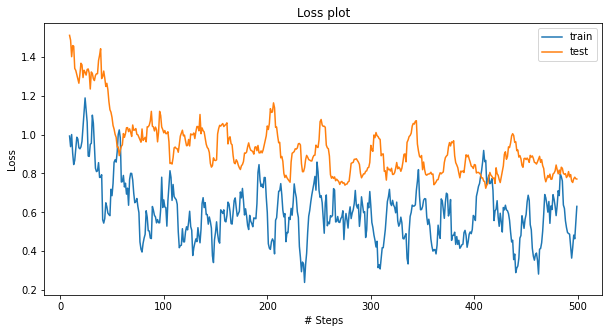

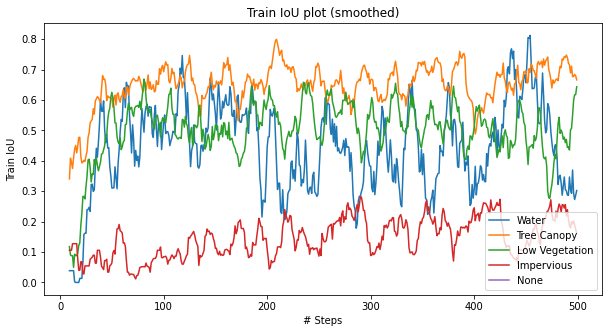

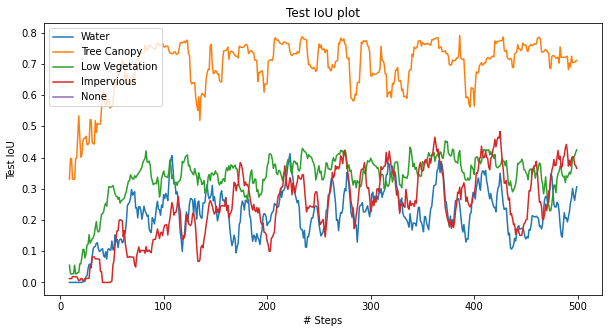

In [ ]:
plot_log(losses, test_losses, IoU, test_IoU, rolling = 10, none_flag = True)

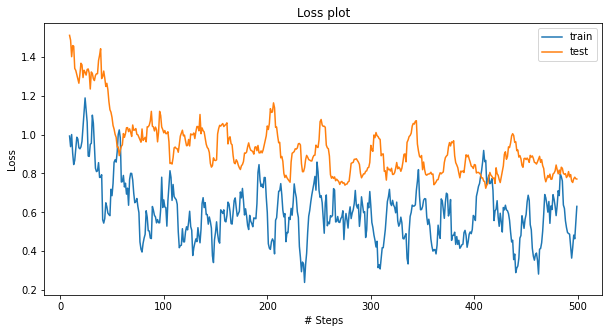

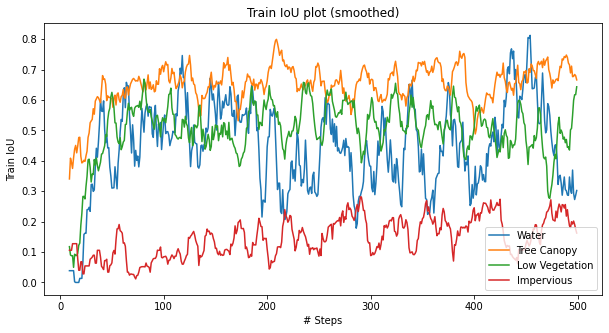

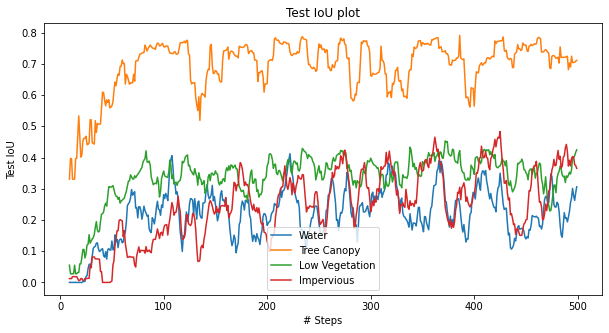

In [ ]:
plot_log(losses, test_losses, IoU, test_IoU, rolling = 10, none_flag = False)

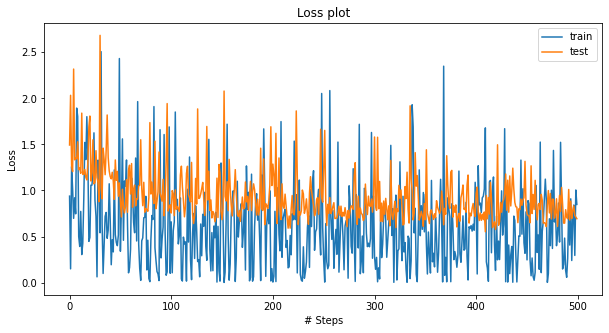

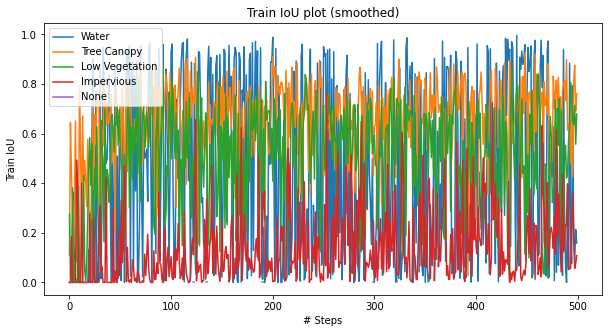

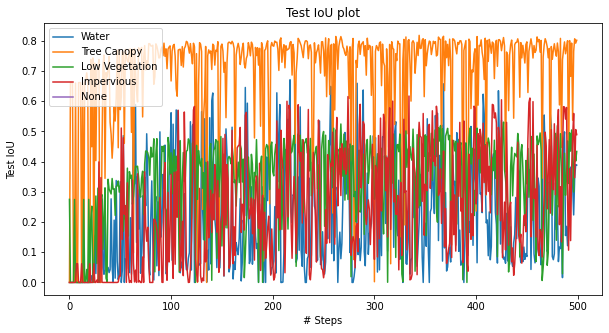

In [ ]:
plot_log(losses, test_losses, IoU, test_IoU, rolling = 1, none_flag = True)

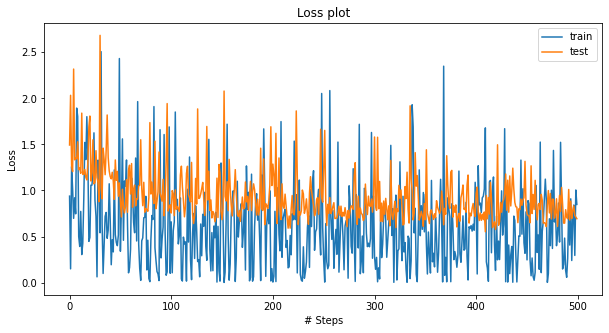

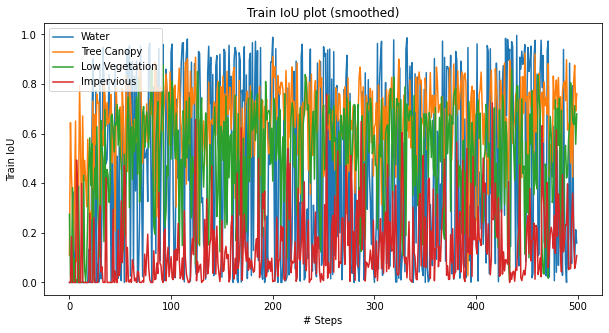

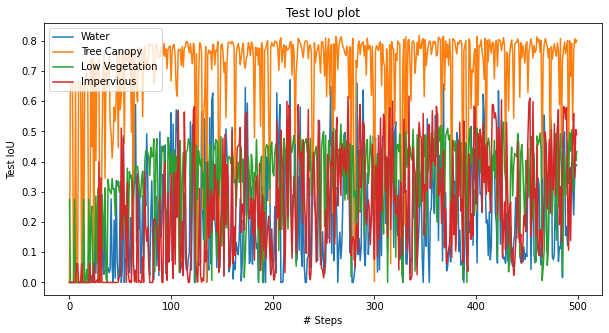

In [ ]:
plot_log(losses, test_losses, IoU, test_IoU, rolling = 1, none_flag = False)

# Visualization of Results

In [ ]:
def make_rgb_label(label_np):
    """
    0: Water, 1: Tree Canopy, 2: Low Vegetation, 3: Impervious
    light blue: Water, dark green: Tree Canopy, light green: Low Vegetation, red: Impervious
    """
    label_np_rgb = np.zeros((len(label_np), 3880, 3880, 3), dtype = np.uint8)
    for i in range(len(label_np)):
        label_np_rgb[i][label_np[i] == 0, :] = [0, 225, 225]
        label_np_rgb[i][label_np[i] == 1, :] = [0, 128, 0]
        label_np_rgb[i][label_np[i] == 2, :] = [0, 225, 0]
        label_np_rgb[i][label_np[i] == 3, :] = [255, 0, 0]

    return(label_np_rgb)

In [ ]:
test_label_loader_rgb = sorted(
    [file for file in os.listdir('/content/drive/MyDrive/JPMC3-2-pt2y/data/test_label_hr')
    if file.endswith('.npy') & (file.find("rgb") > -1)])
title_1 = re.search('-.*\.', test_label_loader_rgb[0]).group()[1:-1]
title_2 = re.search('-.*\.', test_label_loader_rgb[1]).group()[1:-1]

## Test NAIP image

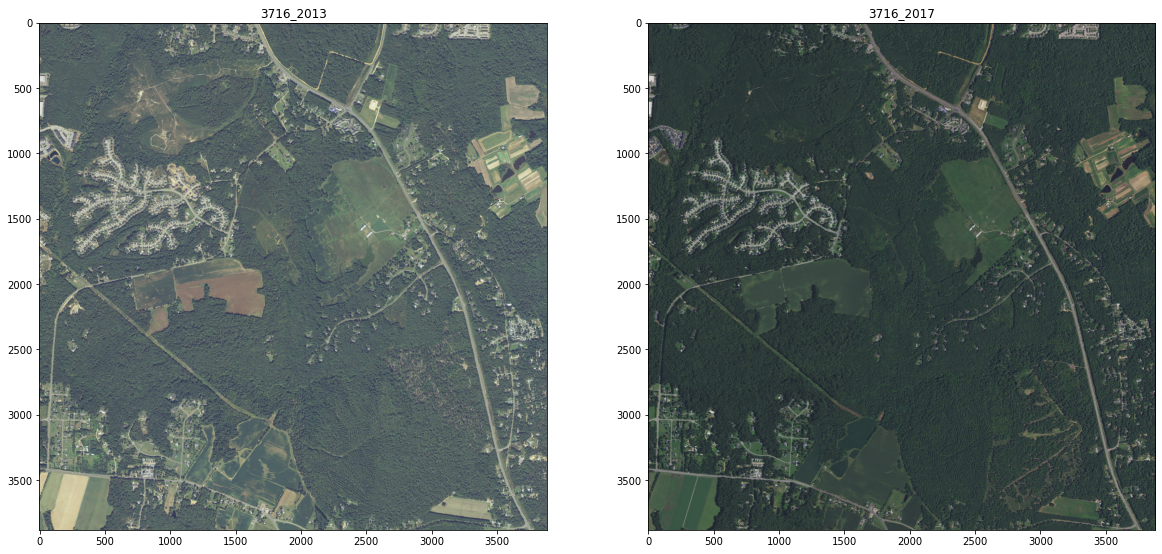

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].imshow(np.transpose(test_image_np_s[0], (1, 2, 0))[:, :, :3])
ax[0].set_title(title_1)
ax[1].imshow(np.transpose(test_image_np_s[1], (1, 2, 0))[:, :, :3])
ax[1].set_title(title_2)
plt.show()

## High-resolution manually curated label for test NAIP image (Ground truth)

In [ ]:
hr_label_s_rgb = []
for file in test_label_loader_rgb:
    if file.endswith('.npy'):
        test_label_np_rgb = np.load(
            os.path.join('/content/drive/MyDrive/JPMC3-2-pt2y/data/test_label_hr', file), gdal.GA_ReadOnly)
        hr_label_s_rgb.append(padding(test_label_np_rgb, rgb_or_gray = "rgb", image_or_label = "label"))

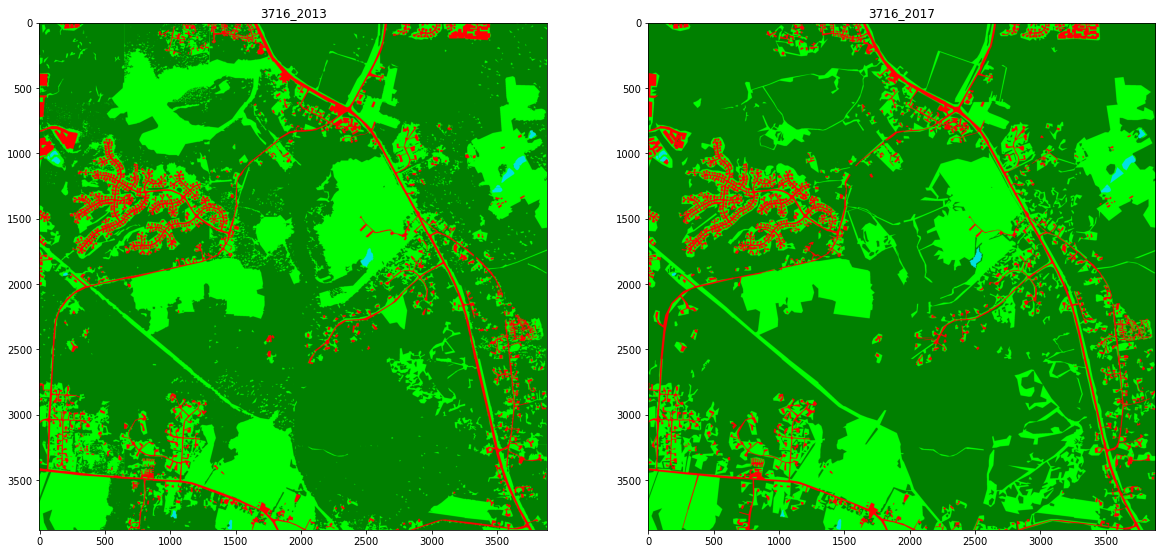

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].imshow(hr_label_s_rgb[0])
ax[0].set_title(title_1)
ax[1].imshow(hr_label_s_rgb[1])
ax[1].set_title(title_2)
plt.show()

## Model prediction for Test NAIP image

In [ ]:
test_preds_np_rgb = make_rgb_label(test_preds.to('cpu').detach().numpy().copy())

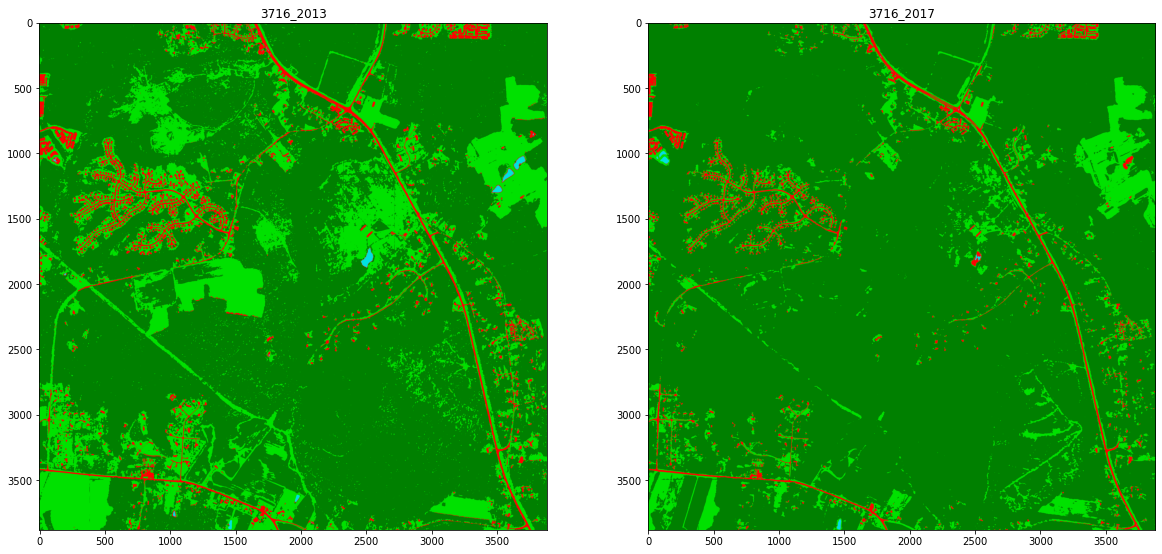

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].imshow(test_preds_np_rgb[0])
ax[0].set_title(title_1)
ax[1].imshow(test_preds_np_rgb[1])
ax[1].set_title(title_2)
plt.show()

## Low-resolution label for test NAIP

In [ ]:
#Download the NLCD label .tif file in a folder and set the link to it 
nlcd_np_s = []
test_nlcd_loader = sorted(
    [file for file in os.listdir('/content/drive/MyDrive/JPMC3-2-pt2y/data/test_label_lr')
     if file.endswith('.tif')])
for file in test_nlcd_loader:
    ds = gdal.Open(os.path.join('/content/drive/MyDrive/JPMC3-2-pt2y/data/test_label_lr', file), gdal.GA_ReadOnly)
    label_np = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
    label_np = np.squeeze(label_np)
    for i, ele in enumerate(NLCD_CLASSES):
        label_np = np.where(label_np == ele, NLCD_IDX_TO_REDUCED_LC_MAP[i], label_np)

    nlcd_np_s.append(padding(label_np, rgb_or_gray = "gray", image_or_label = "label"))

nlcd_np_s_rgb = make_rgb_label(nlcd_np_s)

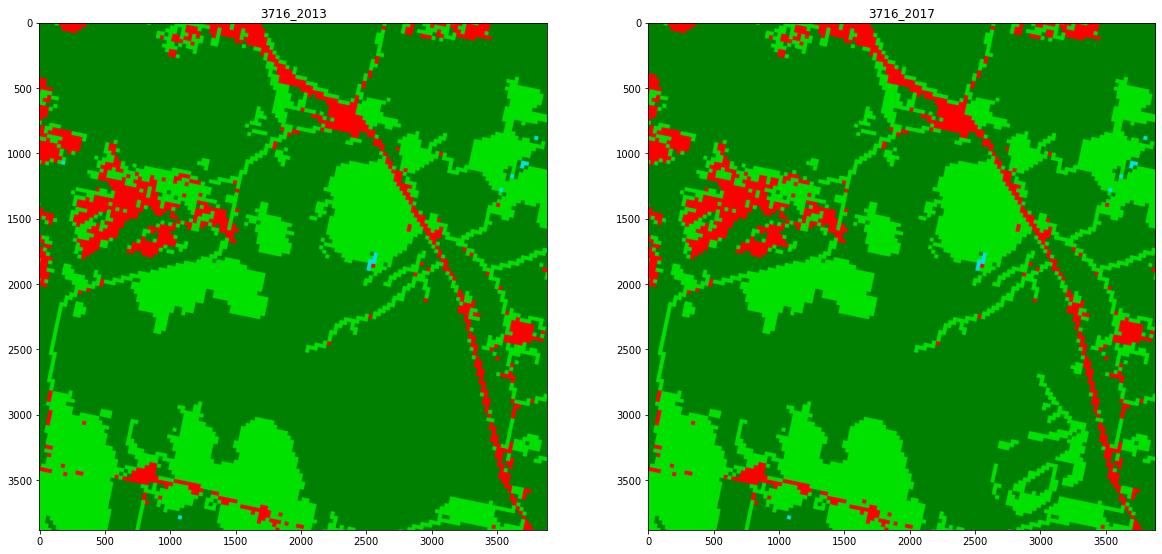

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].imshow(nlcd_np_s_rgb[0])
ax[0].set_title(title_1)
ax[1].imshow(nlcd_np_s_rgb[1])
ax[1].set_title(title_2)
plt.show()

## Aligned images

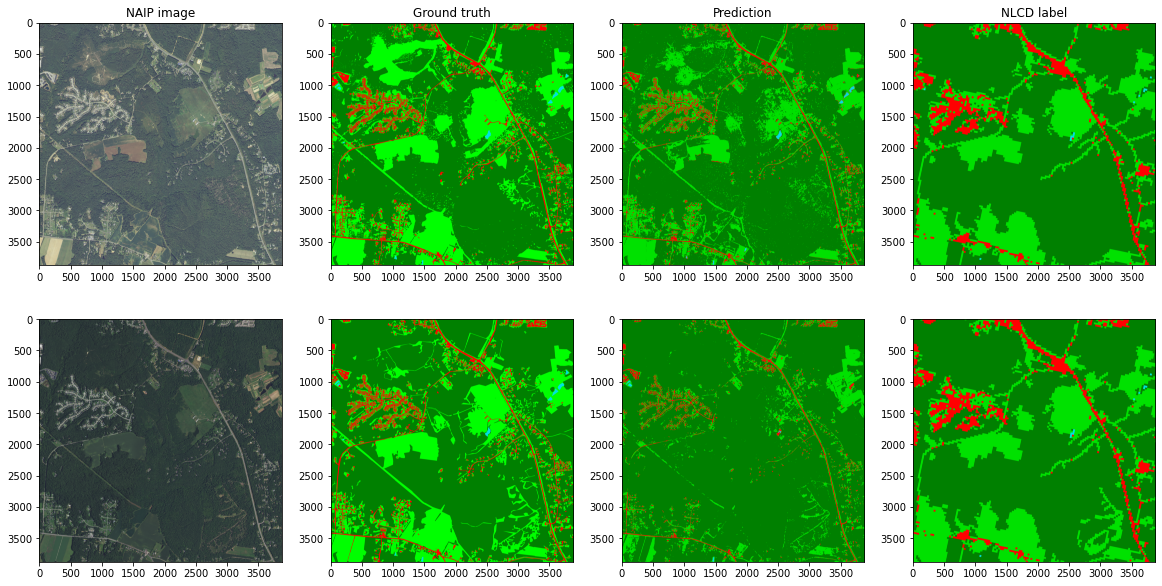

In [ ]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax[0, 0].set_title('NAIP image')
ax[0, 0].imshow(np.transpose(test_image_np_s[0], (1, 2, 0))[:, :, :3])
ax[1, 0].imshow(np.transpose(test_image_np_s[1], (1, 2, 0))[:, :, :3])
ax[0, 1].set_title('Ground truth')
ax[0, 1].imshow(hr_label_s_rgb[0])
ax[1, 1].imshow(hr_label_s_rgb[1])
ax[0, 2].set_title('Prediction')
ax[0, 2].imshow(test_preds_np_rgb[0])
ax[1, 2].imshow(test_preds_np_rgb[1])
ax[0, 3].set_title('NLCD label')
ax[0, 3].imshow(nlcd_np_s_rgb[0])
ax[1, 3].imshow(nlcd_np_s_rgb[1])
plt.show()

#IoU for Gain and Loss

In [ ]:
def calc_GL_IoU(both_year_preds_np, both_year_true_labels_np):
    by_preds_tensor = torch.tensor(both_year_preds_np + 1)
    by_true_labels_tensor = torch.tensor(both_year_true_labels_np + 1)
    preds_change_flag = by_preds_tensor[0] != by_preds_tensor[1]
    true_change_flag = by_true_labels_tensor[0] != by_true_labels_tensor[1]

    by_preds_tensor[0] = by_preds_tensor[0] * preds_change_flag
    by_preds_tensor[1] = by_preds_tensor[1] * preds_change_flag
    by_true_labels_tensor[0] = by_true_labels_tensor[0] * true_change_flag
    by_true_labels_tensor[1] = by_true_labels_tensor[1] * true_change_flag

    print("preds_change_flag:\n", pd.Series(preds_change_flag.flatten()).value_counts())
    print("\ntrue_change_flag:\n", pd.Series(true_change_flag.flatten()).value_counts())

    print("\n\n0: No Change, 1: -Water, 2: -Tree Canopy, 3: -Low Vegetation, 4: -Impervious, 5: -None",
        "\npred_label_2013:\n", pd.Series(by_preds_tensor[0].flatten()).value_counts(),
        "\n\ntest_label_2013:\n", pd.Series(by_true_labels_tensor[0].flatten()).value_counts())

    print("\n\n0: No Change, 1: +Water, 2: +Tree Canopy, 3: +Low Vegetation, 4: +Impervious, 5: +None",
        "\npred_label_2017:\n", pd.Series(by_preds_tensor[1].flatten()).value_counts(),
        "\n\ntest_label_2017:\n", pd.Series(by_true_labels_tensor[1].flatten()).value_counts())
    
    IoU = []
    for i in range(NUM_DFC2021_CLASS - 1):
        IoU.append(calc_IoU(by_preds_tensor[0], by_true_labels_tensor[0], i + 1).item())
    for i in range(NUM_DFC2021_CLASS - 1):
        IoU.append(calc_IoU(by_preds_tensor[1], by_true_labels_tensor[1], i + 1).item())
    IoU.append(np.mean(IoU))

    print(f"\n\nIoU: [-W, -TC, -LV, -I, +W, +TC, +LV, +I, Avg.] = {np.round(IoU, 3)}")

In [ ]:
test_preds_cpu = test_preds.to('cpu').detach().numpy().copy()
test_label_np_cpu = test_label_np_s.to('cpu').detach().numpy().copy()

calc_GL_IoU(test_preds_cpu, test_label_np_cpu)

preds_change_flag:
 False    12419874
True      2634526
dtype: int64

true_change_flag:
 False    12870326
True      2184074
dtype: int64


0: No Change, 1: -Water, 2: -Tree Canopy, 3: -Low Vegetation, 4: -Impervious, 5: -None 
pred_label_2013:
 0.0    12419874
3.0     2163948
4.0      252804
2.0      199318
1.0       18456
dtype: int64 

test_label_2013:
 0.0    12870326
3.0     1273116
2.0      693166
4.0      214240
1.0        3552
dtype: int64


0: No Change, 1: +Water, 2: +Tree Canopy, 3: +Low Vegetation, 4: +Impervious, 5: +None 
pred_label_2017:
 0.0    12419874
2.0     2222451
3.0      350485
4.0       57211
1.0        4379
dtype: int64 

test_label_2017:
 0.0    12870326
2.0     1171683
3.0      811686
4.0      197659
1.0        3046
dtype: int64


IoU: [-W, -TC, -LV, -I, +W, +TC, +LV, +I, Avg.] = [0.028 0.134 0.146 0.102 0.037 0.14  0.119 0.042 0.094]


## IoU for Gain and Loss by NLCD Difference Algorithm 

In [ ]:
calc_GL_IoU(np.array(nlcd_np_s), test_label_np_cpu)

preds_change_flag:
 False    14835535
True       218865
dtype: int64

true_change_flag:
 False    12870326
True      2184074
dtype: int64


0: No Change, 1: -Water, 2: -Tree Canopy, 3: -Low Vegetation, 4: -Impervious, 5: -None 
pred_label_2013:
 0    14835535
2      199505
3       18482
1         878
dtype: int64 

test_label_2013:
 0.0    12870326
3.0     1273116
2.0      693166
4.0      214240
1.0        3552
dtype: int64


0: No Change, 1: +Water, 2: +Tree Canopy, 3: +Low Vegetation, 4: +Impervious, 5: +None 
pred_label_2017:
 0    14835535
3      195255
4       17452
2        6158
dtype: int64 

test_label_2017:
 0.0    12870326
2.0     1171683
3.0      811686
4.0      197659
1.0        3046
dtype: int64


IoU: [-W, -TC, -LV, -I, +W, +TC, +LV, +I, Avg.] = [0.    0.106 0.002 0.    0.    0.    0.092 0.003 0.025]
